In [1]:
from __future__ import absolute_import, division, print_function
import nest_asyncio

nest_asyncio.apply()

import time
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd
import matplotlib.pyplot as plt

from user import User
from average import Average
from graphing import *
from file_related import *
from inits import *
from trainers import *

from tensorflow import keras
from sklearn.model_selection import train_test_split

import collections
import warnings

from six.moves import range
import six

SEED = 0


# This needs tensorflow_federated and nest_asyncio for it
# I used a different environment for the tff experiments.


In [2]:
# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline

#@test {"skip": true}

# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# NOTE: The high-performance executor components used in this tutorial are not
# yet included in the released pip package; you may need to compile from source.

# NOTE: Jupyter requires a patch to asyncio.


warnings.simplefilter('ignore')

tf.compat.v1.enable_v2_behavior()

# np.random.seed(0)

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
# instead to use the default reference runtime.
if six.PY3:
    tff.framework.set_default_executor(tff.framework.create_local_executor())

print(tff.federated_computation(lambda: 'It works!')())

b'It works!'


In [3]:
from tensorflow_federated.python.simulation import hdf5_client_data
# https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/simulation/hdf5_client_data_test.py
# https://github.com/tensorflow/federated/blob/v0.11.0/tensorflow_federated/python/simulation/hdf5_client_data.py
# http://docs.h5py.org/en/stable/high/group.html#Group.create_dataset
# https://stackoverflow.com/questions/55434004/create-a-custom-federated-data-set-in-tensorflow-federated
# https://stackoverflow.com/questions/58965488/how-to-create-federated-dataset-from-a-csv-file

file_train = "dataset_train.hdf5"
file_test = "dataset_test.hdf5"

df = read_file("../datasets/allUsers.lcl.csv")
df_train, df_test = split_dataframe_tff(df, test_size = 0.2)

n1 = create_hdf5(df_train,file_train,0)
n2 = create_hdf5(df_test,file_test,0)

if n1==n2:
    NUM_CLIENTS = n1
else:
    raise 

train = hdf5_client_data.HDF5ClientData(file_train)
test = hdf5_client_data.HDF5ClientData(file_test)


In [4]:
NUM_EPOCHS = 16
BATCH_SIZE = 20
SHUFFLE_BUFFER = 0

def preprocess(dataset):

    def element_fn(element):
        return collections.OrderedDict([
            ('x', tf.reshape(element['points'], [-1])),
            ('y', tf.reshape(element['label'], [1])),
        ])
    return dataset.repeat(NUM_EPOCHS).map(element_fn).batch(BATCH_SIZE)
#     return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
#       SHUFFLE_BUFFER).batch(BATCH_SIZE)

def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

def model_fn():
    keras_model = init_model()
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

sample_clients = train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(train, sample_clients)
federated_test_data = make_federated_data(test, sample_clients)

len(federated_train_data), federated_train_data[0]

(14,
 <BatchDataset shapes: OrderedDict([(x, (None, 36)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.float32)])>)

In [5]:

example_dataset = train.create_tf_dataset_for_client(
    train.client_ids[11])

example_element = iter(example_dataset).next()

print(example_element['points'].numpy())
print(example_element["label"].numpy())

preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next())
# type(train)
# print(sample_batch["y"])

# print(sample_batch["x"].shape)
# print(sample_batch["y"].shape)

[ 81.092766  115.87286   -23.682505   69.05623   -37.713505  -49.422874
  93.143105   97.44857   -36.04848   104.35408     9.425724  -50.929794
  57.29765    66.84091   -12.179954   74.78518    52.417294  -22.879246
  90.16965   -11.415377  -45.997704   33.773605   69.97925    -8.4139
  57.78809   120.86517   -18.853048   -2.3338203  70.972336   -4.3896394
   0.          0.          0.          0.          0.          0.       ]
1.0


In [6]:
iterative_process = tff.learning.build_federated_averaging_process(model_fn)
print(str(iterative_process.initialize.type_signature))
state = iterative_process.initialize()

state, metrics = iterative_process.next(state, federated_train_data)
print('round  0, metrics={}'.format(metrics))
NUM_ROUNDS = 16
for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


( -> <model=<trainable=<dense/kernel=float32[36,512],dense/bias=float32[512],dense_1/kernel=float32[512,128],dense_1/bias=float32[128],dense_2/kernel=float32[128,32],dense_2/bias=float32[32],dense_3/kernel=float32[32,5],dense_3/bias=float32[5]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  0, metrics=<sparse_categorical_accuracy=0.9867468476295471,loss=0.0546971932053566>
round  1, metrics=<sparse_categorical_accuracy=0.9918352365493774,loss=0.026281611993908882>
round  2, metrics=<sparse_categorical_accuracy=0.9933839440345764,loss=0.021404266357421875>
round  3, metrics=<sparse_categorical_accuracy=0.9940652251243591,loss=0.020101679489016533>
round  4, metrics=<sparse_categorical_accuracy=0.994291365146637,loss=0.019321998581290245>
round  5, metrics=<sparse_categorical_accuracy=0.9947645664215088,loss=0.01793183758854866>
round  6, metrics=<sparse_categorical_accuracy=0.9949256181716919,loss=0.017349833622574806>
round  

In [7]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
# str(evaluation.type_signature)
train_metrics = evaluation(state.model, federated_test_data)
str(train_metrics)


'<sparse_categorical_accuracy=0.7947388887405396,loss=1.2228577136993408>'

In [8]:
# SEED = 0
df = read_file("../dataset/allUsers.lcl.csv")
df = shuffle_df(df, SEED)
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
# df.head()

In [9]:
DEVICE = '/cpu:0'
ROUNDS = 16
EPOCHS = 16 # 16 is good
# forces tensorfor to the a particular device to run things
with tf.device(DEVICE):
#     averaging_methods = [Average.all]
#      # return a dictionary of users with data
    users_all, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED, test_size=0.2, val_size=0.0001)
    train_fed(users = users_all, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
              averaging_post = True,
              averaging_metric = "accuracy")

Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
******************************** DONE ********************************
********************************  1   ********************************
******************************** DONE ********************************
********************************  2   ********************************
******************************** DONE ********************************
********************************  3   ********************************
******************************** DONE ********************************
********************************  4   ********************************
******************************** DONE ********************************
********************************  5   ********************************
******************************** DONE ********************************
*****************************

All
For central
Final values for Pre-fit accuracy
Position                   Pre
Round                       15
Average               0.761871
Standard Deviation    0.187859
Minimum                0.40404
Maximum               0.979405
Name: 30, dtype: object
Final values for Post-fit accuracy
Position                   Post
Round                        15
Average                0.966103
Standard Deviation    0.0823354
Minimum                 0.69697
Maximum                       1
Name: 31, dtype: object



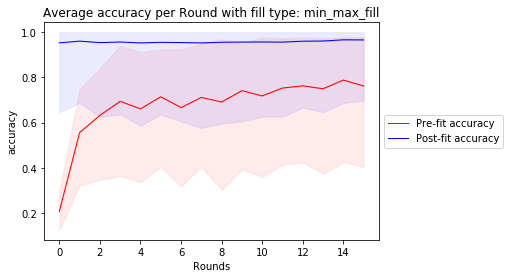

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.785635
3     1     0.722458
5     2     0.746401
7     4     0.460526
9     5     0.489716
11    6     0.894977
13    7     0.404040
15    8     0.769626
17    9     0.859694
19   10     0.908094
21   11     0.978301
23   12     0.905447
25   13     0.979405
Averaged: 0.7618708335436307

Final accuracy for Post-fit data
   User  Final Value
0     0     0.991713
2     1     0.995763
4     2     0.994463
6     4     0.894737
8     5     0.999021
10    6     1.000000
12    7     0.696970
14    8     0.996332
16    9     0.998724
18   10     0.997389
20   11     0.996280
22   12     0.997944
24   13     1.000000
Averaged: 0.9661027101370004



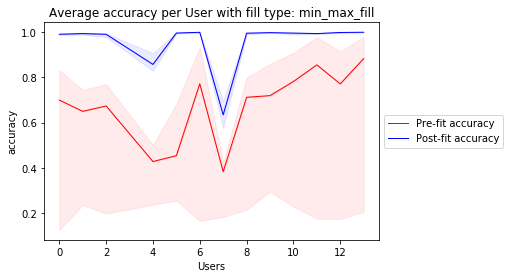

<Figure size 432x288 with 0 Axes>

In [10]:
ignore_first_n = 0
final_values = True



print("All")

# print("For p2p")


# df_avg_round_stats_acc = avg_round_stats(users_all_2, 
#                                          ignore_first_n = ignore_first_n, 
#                                          min_max_fill = True, 
#                                          metric = "accuracy",
#                                          final_values = final_values)
# df_avg_user_stats_acc = avg_user_stats(users_all_2, 
#                                        ignore_first_n = ignore_first_n, 
#                                        min_max_fill = True, 
#                                        metric = "accuracy",
#                                        final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)